# Benchmark Analysis

In [47]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any

%matplotlib inline

In [49]:
matplotlib.style.use('seaborn-v0_8')  

In [50]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL'

In [51]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


## Utils 

In [52]:
def get_path(*entries):
    return os.path.join(*entries)

In [53]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [54]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [55]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '1048576', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [56]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 1048576) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [57]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 1048576) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

# Nebulah all Core

```
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
Address sizes:       43 bits physical, 48 bits virtual
CPU(s):              64
On-line CPU(s) list: 0-63
Thread(s) per core:  1
Core(s) per socket:  32
Socket(s):           2
NUMA node(s):        8
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               1
Model name:          AMD EPYC 7551 32-Core Processor
Stepping:            2
CPU MHz:             2404.199
CPU max MHz:         2000.0000
CPU min MHz:         1200.0000
BogoMIPS:            3992.24
Virtualization:      AMD-V
L1d cache:           32K
L1i cache:           64K
L2 cache:            512K
L3 cache:            8192K
NUMA node0 CPU(s):   0,8,16,24,32,40,48,56
NUMA node1 CPU(s):   2,10,18,26,34,42,50,58
NUMA node2 CPU(s):   4,12,20,28,36,44,52,60
NUMA node3 CPU(s):   6,14,22,30,38,46,54,62
NUMA node4 CPU(s):   1,9,17,25,33,41,49,57
NUMA node5 CPU(s):   3,11,19,27,35,43,51,59
NUMA node6 CPU(s):   5,13,21,29,37,45,53,61
NUMA node7 CPU(s):   7,15,23,31,39,47,55,63
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid amd_dcm aperfmperf pni pclmulqdq monitor ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb hw_pstate sme ssbd sev ibpb vmmcall fsgsbase bmi1 avx2 smep bmi2 rdseed adx smap clflushopt sha_ni xsaveopt xsavec xgetbv1 xsaves clzero irperf xsaveerptr arat npt lbrv svm_lock nrip_save tsc_scale vmcb_clean flushbyasid decodeassists pausefilter pfthreshold avic v_vmsave_vmload vgif overflow_recov succor smca
```

## H1
> Some parallel backends exhibit better performance and scalability when handling nested parallelism for homogeneous
> workloads
>

### Time 

#### Time Comparison - `b1_1_for_each_linear_par`
Check how the runtime without constraining the threads develops with increasing input size

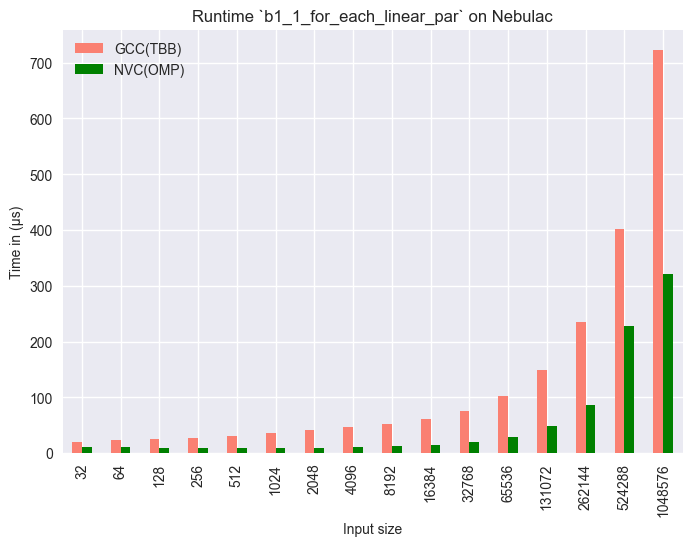

In [58]:
# load data gcc (b1_1_for_each_linear_par)
b1_1_for_each_linear_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_1_for_each_linear_par__Default.csv',COMP="GCC(TBB)")

b1_1_for_each_linear_par_gcc = b1_1_for_each_linear_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_1_for_each_linear_par_gcc = b1_1_for_each_linear_par_gcc.rename(columns={'real_time':'GCC(TBB)'})

# load data nvhpc (b1_1_for_each_linear_par)
b1_1_for_each_linear_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_1_for_each_linear_par__Default.csv', COMP="NVC(OMP)")

b1_1_for_each_linear_par_nvc_omp = b1_1_for_each_linear_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_1_for_each_linear_par_nvc_omp = b1_1_for_each_linear_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})


# merge for ploting 
b1_1_for_each_linear_par_time_merged = pd.merge(b1_1_for_each_linear_par_gcc, b1_1_for_each_linear_par_nvc_omp, on='n')
b1_1_for_each_linear_par_time_merged

# convert time from ns to microseconds because otherwise it will look really bad
b1_1_for_each_linear_par_time_merged['GCC(TBB)'] = b1_1_for_each_linear_par_time_merged['GCC(TBB)'] / 1_000
b1_1_for_each_linear_par_time_merged['NVC(OMP)'] = b1_1_for_each_linear_par_time_merged['NVC(OMP)'] / 1_000


# plot
b1_1_for_each_linear_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (µs)')
plt.xlabel('Input size')
plt.title('Runtime `b1_1_for_each_linear_par` on Nebulac')

plt.show()

#### Time Comparison - `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par`
Check how the runtime without constraining the threads develops with increasing input size

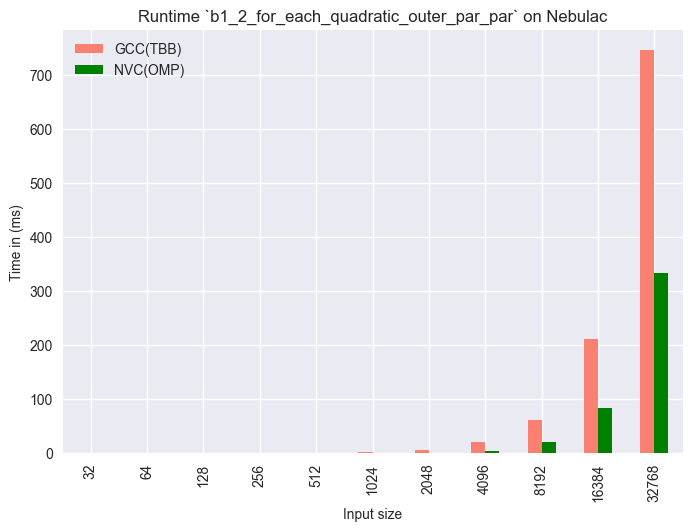

In [59]:
# load data gcc (b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par)
b1_2_for_each_quadratic_par_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par__Default.csv',COMP="GCC(TBB)")

b1_2_for_each_quadratic_par_par_gcc = b1_2_for_each_quadratic_par_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_2_for_each_quadratic_par_par_gcc = b1_2_for_each_quadratic_par_par_gcc.rename(columns={'real_time':'GCC(TBB)'})


# load data nvhpc (b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par)
b1_2_for_each_quadratic_par_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par__Default.csv',COMP="NVC(OMP)")

b1_2_for_each_quadratic_par_par_nvc_omp = b1_2_for_each_quadratic_par_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_2_for_each_quadratic_par_par_nvc_omp = b1_2_for_each_quadratic_par_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})

# merge for ploting 
b1_2_for_each_quadratic_par_par_time_merged = pd.merge(b1_2_for_each_quadratic_par_par_gcc, b1_2_for_each_quadratic_par_par_nvc_omp, on='n')

# convert time from ns to milliseconds because otherwise it will look really bad
b1_2_for_each_quadratic_par_par_time_merged['GCC(TBB)'] = b1_2_for_each_quadratic_par_par_time_merged['GCC(TBB)'] / 1_000_000
b1_2_for_each_quadratic_par_par_time_merged['NVC(OMP)'] = b1_2_for_each_quadratic_par_par_time_merged['NVC(OMP)'] / 1_000_000

# plot
b1_2_for_each_quadratic_par_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (ms)')
plt.xlabel('Input size')
plt.title('Runtime `b1_2_for_each_quadratic_outer_par_par` on Nebulac')

plt.show()

Adding a second graph because small numbers are not readable in the above graph

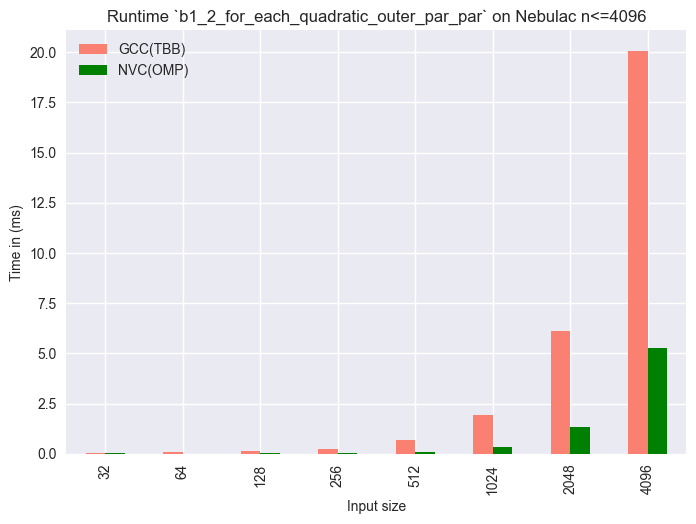

In [60]:
b1_2_for_each_quadratic_par_par_time_merged_sub_4096 = b1_2_for_each_quadratic_par_par_time_merged[b1_2_for_each_quadratic_par_par_time_merged['n'] <= 4096]

# plot
b1_2_for_each_quadratic_par_par_time_merged_sub_4096.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (ms)')
plt.xlabel('Input size')
plt.title('Runtime `b1_2_for_each_quadratic_outer_par_par` on Nebulac n<=4096')

plt.show()

#### Time Comparison - `b1_4_for_each_exponential_par`
Check how the runtime without constraining the threads develops with increasing input size

    GCC(TBB)   n     NVC(OMP)
0   0.018690   4     0.012494
1   0.121331   8     0.042570
2   0.537180  16     1.722970
3  92.126600  32  3170.760000


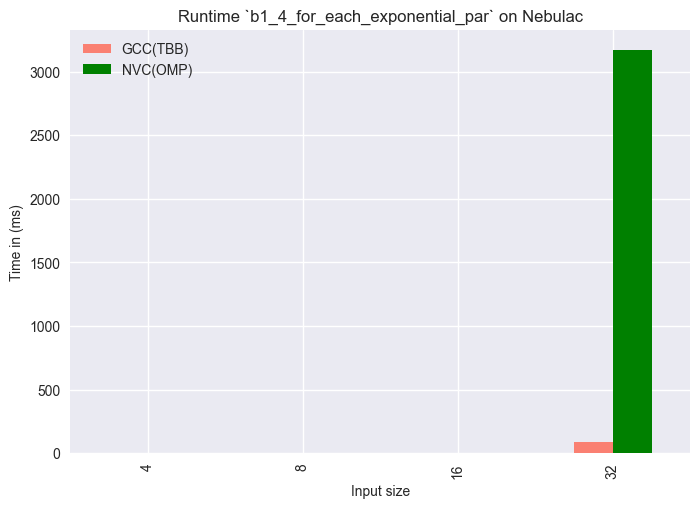

In [61]:
# load data gcc (b1_4_for_each_exponential_par)
b1_4_for_each_exponential_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_4_for_each_exponential_par__Default.csv',COMP="GCC(TBB)")

b1_4_for_each_exponential_par_gcc = b1_4_for_each_exponential_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_4_for_each_exponential_par_gcc = b1_4_for_each_exponential_par_gcc.rename(columns={'real_time':'GCC(TBB)'})

# load data nvhpc (b1_4_for_each_exponential_par)
b1_4_for_each_exponential_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_4_for_each_exponential_par__Default.csv',COMP="NVC(OMP)")

b1_4_for_each_exponential_par_nvc_omp = b1_4_for_each_exponential_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_4_for_each_exponential_par_nvc_omp = b1_4_for_each_exponential_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})


# merge for ploting 
b1_4_for_each_exponential_par_time_merged = pd.merge(b1_4_for_each_exponential_par_gcc, b1_4_for_each_exponential_par_nvc_omp, on='n')

# convert time from ns to milliseconds because otherwise it will look really bad
b1_4_for_each_exponential_par_time_merged['GCC(TBB)'] = b1_4_for_each_exponential_par_time_merged['GCC(TBB)'] / 1_000_000
b1_4_for_each_exponential_par_time_merged['NVC(OMP)'] = b1_4_for_each_exponential_par_time_merged['NVC(OMP)'] / 1_000_000

print(b1_4_for_each_exponential_par_time_merged)

# plot
b1_4_for_each_exponential_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (ms)')
plt.xlabel('Input size')
plt.title('Runtime `b1_4_for_each_exponential_par` on Nebulac')

plt.show()

Adding a second graph because small numbers are not readable in the above graph

   GCC(TBB)   n   NVC(OMP)
0   18.6901   4    12.4941
1  121.3310   8    42.5701
2  537.1800  16  1722.9700


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/1969448607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b1_4_for_each_exponential_par_time_merged_sub_16['GCC(TBB)'] = b1_4_for_each_exponential_par_time_merged_sub_16['GCC(TBB)'] * 1_000
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/1969448607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b1_4_for_each_exponential_par_time_merged_sub_16['NVC(OMP)'] = b1_4_for_each_exponential_par_time_merged_sub_16['NVC(OMP)'] 

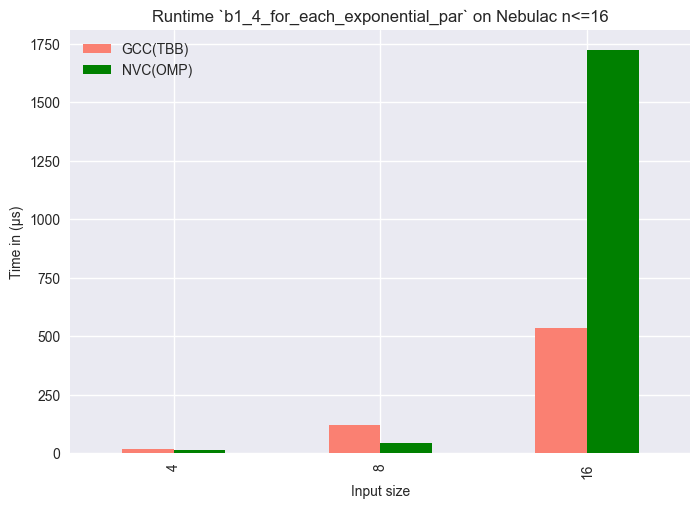

In [62]:
b1_4_for_each_exponential_par_time_merged_sub_16 = b1_4_for_each_exponential_par_time_merged[b1_4_for_each_exponential_par_time_merged['n'] <= 16]

# convert from milliseconds to microseconds 
b1_4_for_each_exponential_par_time_merged_sub_16['GCC(TBB)'] = b1_4_for_each_exponential_par_time_merged_sub_16['GCC(TBB)'] * 1_000
b1_4_for_each_exponential_par_time_merged_sub_16['NVC(OMP)'] = b1_4_for_each_exponential_par_time_merged_sub_16['NVC(OMP)'] * 1_000


# plot
b1_4_for_each_exponential_par_time_merged_sub_16.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

print(b1_4_for_each_exponential_par_time_merged_sub_16)

plt.ylabel('Time in (µs)')
plt.xlabel('Input size')
plt.title('Runtime `b1_4_for_each_exponential_par` on Nebulac n<=16')

plt.show()

### Strong Scaling

`S(p)= T(1) / T(p)`

As based we use once the:
* sequential algorithm 
* parallel algorithm (1 thread)

#### Strong Scaling - `b1_1_for_each_linear` 
1 Million fixed input size with threads 1-64

##### Seq Base

   threads   GCC(TBB)   NVC(OMP)
0        1   0.997915   0.987061
1        2   1.993628   1.971258
2        4   3.966795   3.812405
3        8   7.715379   7.682825
4       16  14.945539  14.531737
5       32  26.258819  25.007096
6       64  42.943653  50.463093


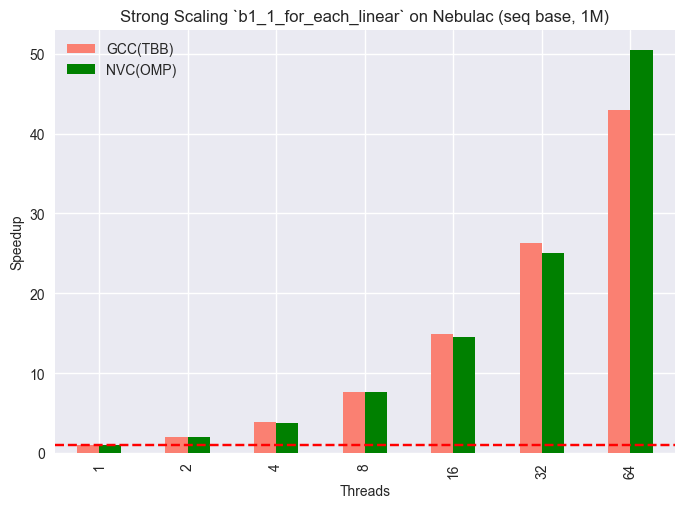

In [63]:
# GCC
## load gcc (b1_1_for_each_linear_seq)
b1_1_for_each_linear_seq_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_1_for_each_linear_seq__Default.csv',COMP="GCC(TBB)")

## load gcc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)")

## calculate speedup
b1_1_for_each_linear_strong_scaling_seqbase_gcc = calc_speedup_based_seq(b1_1_for_each_linear_seq_gcc,b1_1_for_each_linear_threads_gcc,"GCC(TBB)")

# NVC(OMP)
## load nvhpc (b1_1_for_each_linear_seq)
b1_1_for_each_linear_seq_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_1_for_each_linear_seq__Default.csv',COMP="NVC(OMP)")

## load nvhpc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)")

## calculate speedup
b1_1_for_each_linear_strong_scaling_seqbase_nvc_omp = calc_speedup_based_seq(b1_1_for_each_linear_seq_nvc_omp,b1_1_for_each_linear_threads_nvc_omp,"NVC(OMP)")

# merge for plotting 
b1_1_for_each_linear_seq_speedup_merged = pd.merge(b1_1_for_each_linear_strong_scaling_seqbase_gcc, b1_1_for_each_linear_strong_scaling_seqbase_nvc_omp, on='threads')
print(b1_1_for_each_linear_seq_speedup_merged)

# plot strong scaling
ax = b1_1_for_each_linear_seq_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_1_for_each_linear` on Nebulac (seq base, 1M)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  0.997915  0.987061
1        2  0.996814  0.985629
2        4  0.991699  0.953101
3        8  0.964422  0.960353
4       16  0.934096  0.908234
5       32  0.820588  0.781472
6       64  0.670995  0.788486


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/3790263233.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


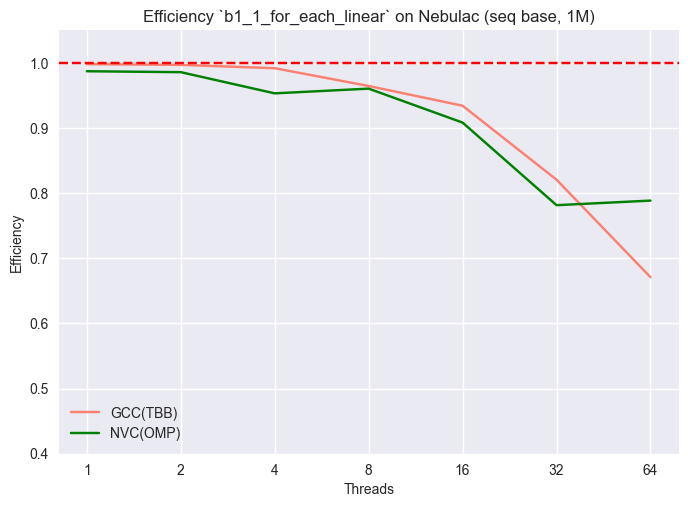

In [64]:
## efficiency graph
b1_1_for_each_linear_seq_efficiency = b1_1_for_each_linear_seq_speedup_merged.copy()
b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] = b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] / b1_1_for_each_linear_seq_efficiency['threads']
b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] = b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] / b1_1_for_each_linear_seq_efficiency['threads']

print(b1_1_for_each_linear_seq_efficiency)

# plot efficiency
ax = b1_1_for_each_linear_seq_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0.4,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_1_for_each_linear` on Nebulac (seq base, 1M)')

plt.show()

##### Par(1) Base

   threads   GCC(TBB)   NVC(OMP)
0        1   1.000000   1.000000
1        2   1.997794   1.997099
2        4   3.975084   3.862382
3        8   7.731503   7.783538
4       16  14.976772  14.722232
5       32  26.313694  25.334912
6       64  43.033396  51.124609


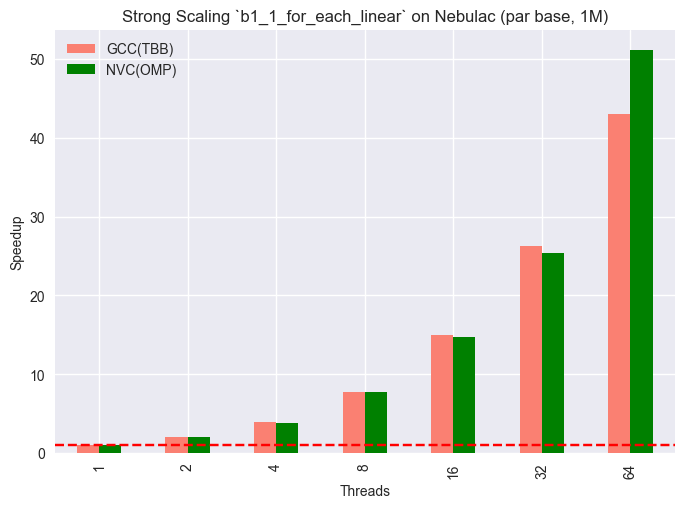

In [65]:
# GCC(TBB)
## load gcc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)")

## calc strong scaling 
b1_1_for_each_linear_strong_scaling_parbase_gcc = calc_speedup_based_par(b1_1_for_each_linear_threads_gcc,"GCC(TBB)")

# NVC(OMP)
## load nvhpc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)")

## calc strong scaling
b1_1_for_each_linear_strong_scaling_parbase_nvc_omp = calc_speedup_based_par(b1_1_for_each_linear_threads_nvc_omp,"NVC(OMP)")


# merge for plotting 
b1_1_for_each_linear_seq_parbase_speedup_merged = pd.merge(b1_1_for_each_linear_strong_scaling_parbase_gcc, b1_1_for_each_linear_strong_scaling_parbase_nvc_omp, on='threads')
print(b1_1_for_each_linear_seq_parbase_speedup_merged)

# plot strong scaling
ax = b1_1_for_each_linear_seq_parbase_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_1_for_each_linear` on Nebulac (par base, 1M)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  1.000000  1.000000
1        2  0.998897  0.998549
2        4  0.993771  0.965595
3        8  0.966438  0.972942
4       16  0.936048  0.920140
5       32  0.822303  0.791716
6       64  0.672397  0.798822


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/3088997708.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


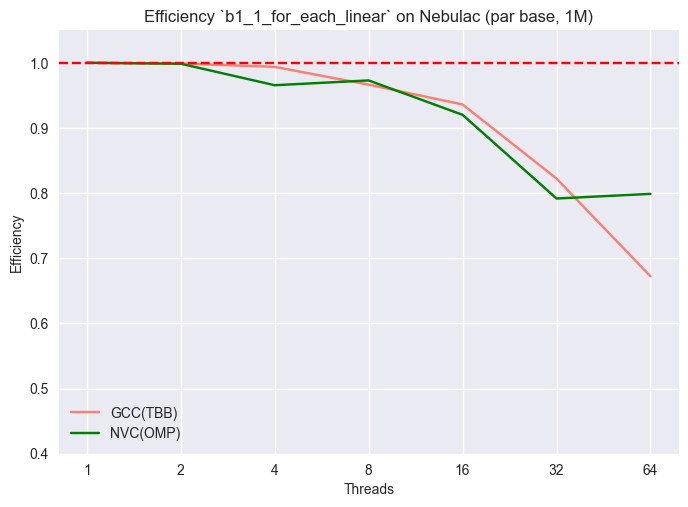

In [66]:
## efficiency graph
b1_1_for_each_linear_seq_efficiency = b1_1_for_each_linear_seq_parbase_speedup_merged.copy()
b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] = b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] / b1_1_for_each_linear_seq_efficiency['threads']
b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] = b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] / b1_1_for_each_linear_seq_efficiency['threads']

print(b1_1_for_each_linear_seq_efficiency)

# plot efficiency
ax = b1_1_for_each_linear_seq_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0.4,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_1_for_each_linear` on Nebulac (par base, 1M)')

plt.show()

#### Strong Scaling - `b1_2_for_each_quadratic` 
1 Million fixed input size with threads 1-64

##### Seq Base

Here we wont do it with seq base because its not really realistic

##### Par(1) Base

   threads   GCC(TBB)   NVC(OMP)
0        1   1.000000   1.000000
1        2   2.012084   1.989333
2        4   4.028875   3.965606
3        8   8.029452   7.085557
4       16  15.840287  15.510771
5       32  27.573592  23.361771
6       64  49.508283  32.807058


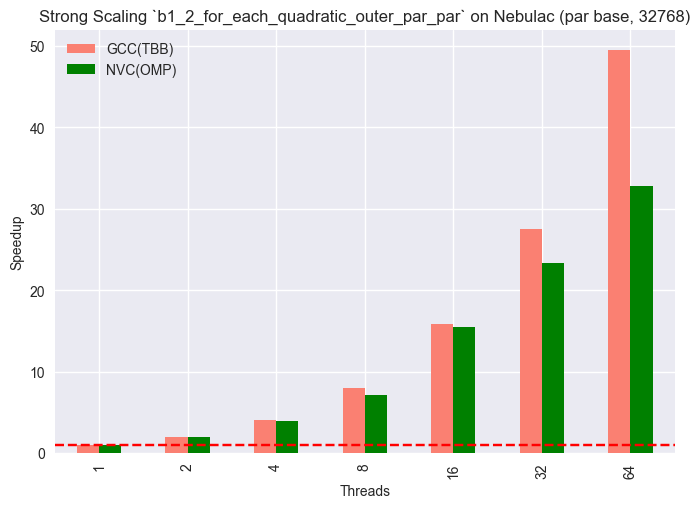

In [67]:
# GCC(TBB)
## load gcc threaded b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par 
b1_2_for_each_quadratic_par_par_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)",input_size=32768)

## calc strong scaling
b1_2_for_each_quadratic_par_par_scaling_parbase_gcc = calc_speedup_based_par(b1_2_for_each_quadratic_par_par_threads_gcc,"GCC(TBB)")

# NVC(OMP)
## load nvhpc threaded b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par 
b1_2_for_each_quadratic_par_par_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)",input_size=32768)

## calc strong scaling 
b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp = calc_speedup_based_par(b1_2_for_each_quadratic_par_par_threads_nvc_omp,"NVC(OMP)")

# merge for plotting
b1_2_for_each_quadratic_par_par_speedup_merged = pd.merge(b1_2_for_each_quadratic_par_par_scaling_parbase_gcc, b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp, on='threads')
print(b1_2_for_each_quadratic_par_par_speedup_merged)

# plot strong scaling
ax = b1_2_for_each_quadratic_par_par_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_2_for_each_quadratic_outer_par_par` on Nebulac (par base, 32768)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  1.000000  1.000000
1        2  1.006042  0.994667
2        4  1.007219  0.991402
3        8  1.003681  0.885695
4       16  0.990018  0.969423
5       32  0.861675  0.730055
6       64  0.773567  0.512610


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/328153834.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


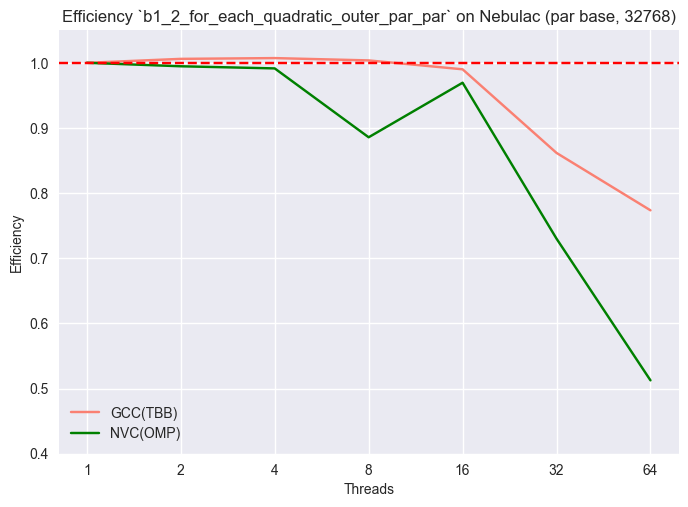

In [68]:
## efficiency graph
b1_2_for_each_quadratic_par_par_efficiency = b1_2_for_each_quadratic_par_par_speedup_merged.copy()
b1_2_for_each_quadratic_par_par_efficiency['GCC(TBB)'] = b1_2_for_each_quadratic_par_par_efficiency['GCC(TBB)'] / b1_2_for_each_quadratic_par_par_efficiency['threads']
b1_2_for_each_quadratic_par_par_efficiency['NVC(OMP)'] = b1_2_for_each_quadratic_par_par_efficiency['NVC(OMP)'] / b1_2_for_each_quadratic_par_par_efficiency['threads']

print(b1_2_for_each_quadratic_par_par_efficiency)

# plot efficiency
ax = b1_2_for_each_quadratic_par_par_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0.4,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_2_for_each_quadratic_outer_par_par` on Nebulac (par base, 32768)')

plt.show()

#### Strong Scaling - `b1_4_for_each_exponential` 
32 fixed input size with threads 1-64

##### Seq Base

   threads  GCC(TBB)  NVC(OMP)
0        1  0.220355  0.210447
1        2  0.362259  0.195431
2        4  0.566315  0.223379
3        8  1.145408  0.173250
4       16  2.241314  0.190904
5       32  3.970097  0.171405
6       64  6.585767  0.217449


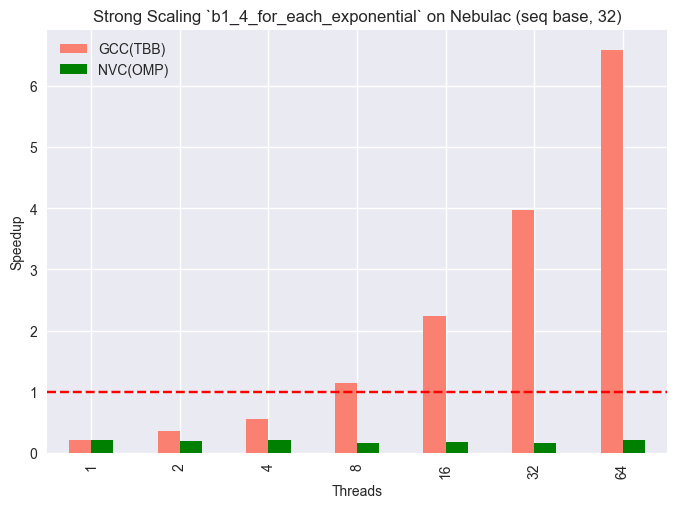

In [69]:
# GCC
## load gcc (b1_4_for_each_exponential_seq)
b1_4_for_each_exponential_seq_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_4_for_each_exponential_seq__Default.csv',COMP="GCC(TBB)")

## load gcc threaded b1_4_for_each_exponential_par 
b1_4_for_each_exponential_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)",input_size=32)

## calculate speedup
b1_4_for_each_exponential_strong_scaling_seqbase_gcc = calc_speedup_based_seq(b1_4_for_each_exponential_seq_gcc,b1_4_for_each_exponential_threads_gcc,"GCC(TBB)",input_size=32)

# NVC(OMP)
## load nvhpc (b1_4_for_each_exponential_seq)
b1_4_for_each_exponential_seq_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_4_for_each_exponential_seq__Default.csv',COMP="NVC(OMP)")

## load nvhpc threaded b1_4_for_each_exponential_par
b1_4_for_each_exponential_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)",input_size=32) 

## calculate speedup
b1_4_for_each_exponential_strong_scaling_seqbase_nvc_omp = calc_speedup_based_seq(b1_4_for_each_exponential_seq_nvc_omp,b1_4_for_each_exponential_threads_nvc_omp,"NVC(OMP)",input_size=32)


# merge for plotting 
b1_4_for_each_exponential_seq_speedup_merged = pd.merge(b1_4_for_each_exponential_strong_scaling_seqbase_gcc, b1_4_for_each_exponential_strong_scaling_seqbase_nvc_omp, on='threads')
print(b1_4_for_each_exponential_seq_speedup_merged)

# plot strong scaling
ax = b1_4_for_each_exponential_seq_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_4_for_each_exponential` on Nebulac (seq base, 32)')

plt.show()


   threads  GCC(TBB)  NVC(OMP)
0        1  0.220355  0.210447
1        2  0.181129  0.097715
2        4  0.141579  0.055845
3        8  0.143176  0.021656
4       16  0.140082  0.011931
5       32  0.124066  0.005356
6       64  0.102903  0.003398


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/4127874945.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


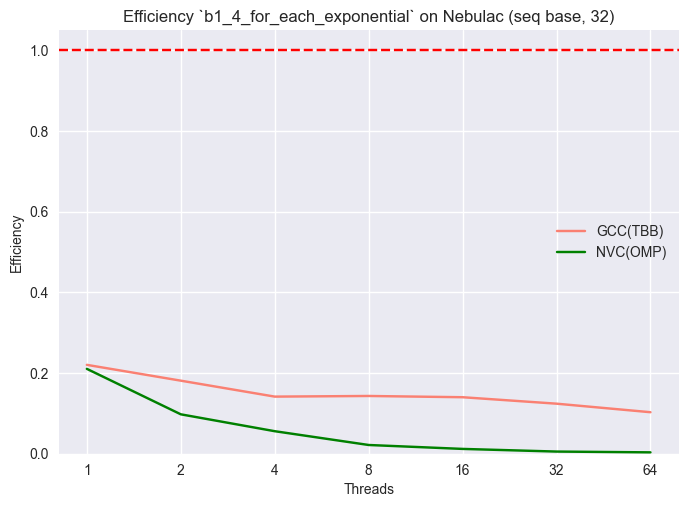

In [70]:
## efficiency graph
b1_4_for_each_exponential_seq_efficiency = b1_4_for_each_exponential_seq_speedup_merged.copy()
b1_4_for_each_exponential_seq_efficiency['GCC(TBB)'] = b1_4_for_each_exponential_seq_efficiency['GCC(TBB)'] / b1_4_for_each_exponential_seq_efficiency['threads']
b1_4_for_each_exponential_seq_efficiency['NVC(OMP)'] = b1_4_for_each_exponential_seq_efficiency['NVC(OMP)'] / b1_4_for_each_exponential_seq_efficiency['threads']

print(b1_4_for_each_exponential_seq_efficiency)

# plot efficiency
ax = b1_4_for_each_exponential_seq_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_4_for_each_exponential` on Nebulac (seq base, 32)')

plt.show()

##### Par(1) Base

   threads   GCC(TBB)  NVC(OMP)
0        1   1.000000  1.000000
1        2   1.643982  0.928644
2        4   2.570017  1.061446
3        8   5.198022  0.823248
4       16  10.171399  0.907134
5       32  18.016857  0.814478
6       64  29.887137  1.033271


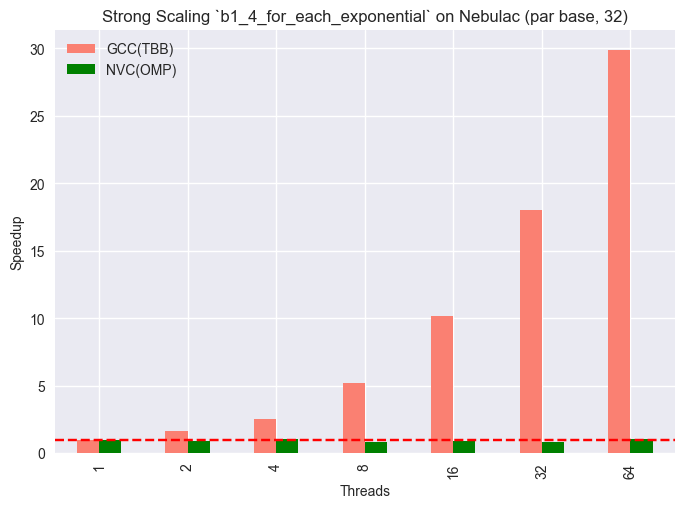

In [71]:
# GCC
## load gcc threaded b1_4_for_each_exponential_par 
b1_4_for_each_exponential_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)",input_size=32)

## calc strong scaling 
b1_4_for_each_exponential_strong_scaling_parbase_gcc = calc_speedup_based_par(b1_4_for_each_exponential_threads_gcc,"GCC(TBB)")


# NVC(OMP)
## load nvhpc threaded b1_4_for_each_exponential_par
b1_4_for_each_exponential_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)",input_size=32) 

## calc strong scaling 
b1_4_for_each_exponential_strong_scaling_parbase_nvc_omp = calc_speedup_based_par(b1_4_for_each_exponential_threads_nvc_omp,"NVC(OMP)")


# merge for plotting 
b1_4_for_each_linear_seq_parbase_speedup_merged = pd.merge(b1_4_for_each_exponential_strong_scaling_parbase_gcc, b1_4_for_each_exponential_strong_scaling_parbase_nvc_omp, on='threads')
print(b1_4_for_each_linear_seq_parbase_speedup_merged)

# plot strong scaling
ax = b1_4_for_each_linear_seq_parbase_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_4_for_each_exponential` on Nebulac (par base, 32)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  1.000000  1.000000
1        2  0.821991  0.464322
2        4  0.642504  0.265362
3        8  0.649753  0.102906
4       16  0.635712  0.056696
5       32  0.563027  0.025452
6       64  0.466987  0.016145


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/2443303117.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


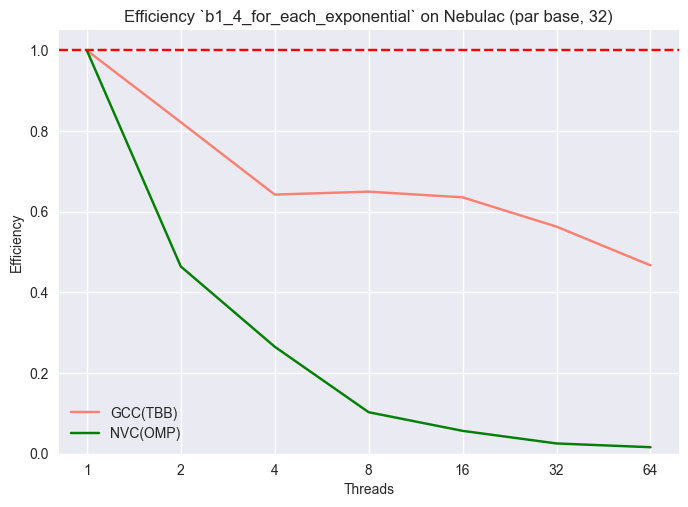

In [72]:
## efficiency graph
b1_4_for_each_linear_seq_parbase_efficiency = b1_4_for_each_linear_seq_parbase_speedup_merged.copy()
b1_4_for_each_linear_seq_parbase_efficiency['GCC(TBB)'] = b1_4_for_each_linear_seq_parbase_efficiency['GCC(TBB)'] / b1_4_for_each_linear_seq_parbase_efficiency['threads']
b1_4_for_each_linear_seq_parbase_efficiency['NVC(OMP)'] = b1_4_for_each_linear_seq_parbase_efficiency['NVC(OMP)'] / b1_4_for_each_linear_seq_parbase_efficiency['threads']

print(b1_4_for_each_linear_seq_parbase_efficiency)

# plot efficiency
ax = b1_4_for_each_linear_seq_parbase_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_4_for_each_exponential` on Nebulac (par base, 32)')

plt.show()

### Performance Portability Calculation (Inter Compiler)

for this group we can "calculate" a performance probability by looking at the strong scaling speedup every compiler has when using the max amount of cores. (aka running with 1M entries at max core) (insipred by [1])

example:

```
|          | achieved | perfect | efficiency  | 
|----------|----------|---------|-------------|
| GCC(TBB) | 12       | 16      | 12/16=0.75  |
| NVC(OMP) | 16       | 16      | 16/16=1     |
| NVC(GPU) | 0        | 0       | 0           |
| Intel    | 14       | 16      | 14/16=0.875 |

Performance Portability for `{GCC(TBB), NVC(OMP), NVC(GPU), Intel}` = 0

Performance Portability for `{GCC(TBB), NVC(OMP), Intel}` = `3/((1/0,75)+ (1/1) + (1/0,875))` = 86.3%

```

In [73]:
max_cores :int = 64


b1_1_data = []
b1_2_data = []
b1_4_data = []

print("GCC")
# calculate efficiency for gcc on max core for `b1_1_for_each_linear`
b1_1_for_each_linear_speed_up_64_gcc = b1_1_for_each_linear_strong_scaling_parbase_gcc[b1_1_for_each_linear_strong_scaling_parbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_1_data.append(b1_1_for_each_linear_speed_up_64_gcc)

print("\tb1_1 Speedup(64):", b1_1_for_each_linear_speed_up_64_gcc)


# calculate efficiency for gcc on max core for `b1_2_for_each_quadratic`
b1_2_for_each_quadratic_par_par_speed_up_64_gcc = b1_2_for_each_quadratic_par_par_scaling_parbase_gcc[b1_2_for_each_quadratic_par_par_scaling_parbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_2_data.append(b1_2_for_each_quadratic_par_par_speed_up_64_gcc)

print("\tb1_2 Speedup(64):", b1_2_for_each_quadratic_par_par_speed_up_64_gcc)



# calculate efficiency for gcc on max core for `b1_4_for_each_exponential`
b1_4_for_each_exponential_speed_up_64_gcc = b1_4_for_each_exponential_strong_scaling_parbase_gcc[b1_4_for_each_exponential_strong_scaling_parbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_4_data.append(b1_4_for_each_exponential_speed_up_64_gcc)

print("\tb1_4 Speedup(64):", b1_4_for_each_exponential_speed_up_64_gcc)


print("\nNVC(OMP)")
# calculate efficiency for nvhpc(mc) on max core for `b1_1_for_each_linear`
b1_1_for_each_linear_speed_up_64_nvc_omp = b1_1_for_each_linear_strong_scaling_parbase_nvc_omp[b1_1_for_each_linear_strong_scaling_parbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_1_data.append(b1_1_for_each_linear_speed_up_64_nvc_omp)

print("\tb1_1 Speedup(64):", b1_1_for_each_linear_speed_up_64_nvc_omp)

# calculate efficiency for nvhpc(mc) on max core for `b1_2_for_each_quadratic`
b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp = b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp[b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_2_data.append(b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp)

print("\tb1_2 Speedup(64):", b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp)

# calculate efficiency for nvhpc(mc) on max core for `b1_4_for_each_exponential`
b1_4_for_each_exponential_speed_up_64_nvc_omp = b1_4_for_each_exponential_strong_scaling_parbase_nvc_omp[b1_4_for_each_exponential_strong_scaling_parbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_4_data.append(b1_4_for_each_exponential_speed_up_64_nvc_omp)
print("\tb1_4 Speedup(64):", b1_4_for_each_exponential_speed_up_64_nvc_omp)

print("\n\n")

# calc
b1_1_perfect = max(b1_1_data)
b1_2_perfect = max(b1_2_data)
b1_4_perfect = max(b1_4_data)


# Performance portability b1_1 inter compiler
b1_1_efficiency = [x / b1_1_perfect for x in b1_1_data]
pp_b1_1 = len(b1_1_efficiency) / (sum([1 / x for x in b1_1_efficiency]))

print("Performance Portability B1_1: " , pp_b1_1)


# Performance portability b1_2 inter compiler
b1_2_efficiency = [x / b1_2_perfect for x in b1_2_data]
pp_b1_2 = len(b1_2_efficiency) / (sum([1 / x for x in b1_2_efficiency]))

print("Performance Portability B1_2: " , pp_b1_2)


# Performance portability b1_4 inter compiler
b1_4_efficiency = [x / b1_4_perfect for x in b1_4_data]
pp_b1_4 = len(b1_4_efficiency) / (sum([1 / x for x in b1_4_efficiency]))

print("Performance Portability B1_4: " , pp_b1_4)



GCC
	b1_1 Speedup(64): 43.03339575922877
	b1_2 Speedup(64): 49.50828342574879
	b1_4 Speedup(64): 29.887136604756876

NVC(OMP)
	b1_1 Speedup(64): 51.12460858208368
	b1_2 Speedup(64): 32.80705823482036
	b1_4 Speedup(64): 1.0332712232351373



Performance Portability B1_1:  0.914067711189745
Performance Portability B1_2:  0.7971067743386567
Performance Portability B1_4:  0.0668342558082125


### Findings for H1

#### `b1_1`
There is a significant runtime difference between parallel backends (TBB and NVC(OMP) ) when we are dealing with quite rudimentary linear homogenous workloads. As you can see in [figure of runtime comparisons](#time-comparison---b1_1_for_each_linear_par). The larger the input size gets the worse the performance of GCC(with TBB) gets. On the other side NVC(with OMP backend) seems to scale quite good under linear homogenous workloads.

For strong scaling we can see that calculating the speedup using the parallel implementation with 1 thread and using the sequential implementation, does not make a huge difference. In fact the overhead for this kind of workload seems to be minimal.
The backends scale fairly good and the absolute speedup for each number of threads does not have a tremendous difference between the two backends. We only start to notice that the more threads we utilize the larger the speedup between GCC(TBB) and NVC(OMP) gets. 

For small number of threads (1-16) we see that the speedup is quite optimal (close to perfect speedup). Only later when utilizing more threads (32+) we start to see a significant performance loss for both GCC(TBB) and NVC(OMP)

Since the performance portability metric used in this hypothesis focuses on the speedup and as observed above and the difference between speedup is not that huge, we achieve a rather high performance portability of **91%**!

Key observations:
* Significant runtime differences between GCC(TBB) and NVC(OMP)
* Speedup seems to be on same level for backends only for huge number of threads it starts to degrade
* Small number of threads nearly perfect speedup for both
* Performance portability quite high since backends behave quite good.


#### `b1_2`
There is a signifcant runtime difference between parallel backends (TBB and NVC(OMP)) when we are dealing with nested quadratic parallelism (aka nested loops with each O(n)). As you can see in [figure of runtime comparisons](#time-comparison---b1_2_for_each_quadratic_outer_stdexecutionparallel_policy_par). The larger the input size gets the worse the performance of GCC(with TBB) gets. On the other side NVC(with OMP backend) seems to scale quite good under quadratic homogenous workloads.

For this benchmark we only considered the outer parallel and inner parallel with 1thread as base to calculate the speedups. GCC(TBB) seems to have better strong scaling than NVC(OMP). It looks like that NVC(OMP) starts to degrade heavily when having high number of threads and this is also visible when looking at the efficiency.

Since the performance portability metric used in this hypothesis focuses on the speedup and as observed above and the difference between speedup is actually quite huge, we achieve a rather poor portability of **79%**!

Key observations:
* Significant runtime differences between GCC(TBB) and NVC(OMP). NVC(OMP) faster than GCC(TBB)
* Speedup difference becomes bigger with rise of threads. 
* NVC(OMP) pretty much collapses at 64 threads.
* Small number of threads quite good for both backends
* Performance portability poor since NVC(OMP) collapses for high number of threads.



#### `b1_4`
The runtime difference between GCC(TBB) and NVC(OMP) is extreme! Since we are dealing with exponential runtime it was expected that the runtime will increase fast, but the runtimes of NVC(OMP) exploded. At first the runtime of GCC(TBB) is worse than the of NVC(OMP), but when for larger input sizes the trend turns and the runtime of NVC(OMP) exploded and making GCC(TBB) faster by a magnitude.


For this kind of nested parallelism strong scaling does looks really bad. Using the sequential algorithm or the parallel algorithm with 1 Thread as base does not have an effect on the speedup for NVC(OMP). NVC(OMP) has really bad strong scaling and often does not even break the 1x speedup. On the other hand GCC(TBB) does improve significantly with more core reaching a speedup of more than 30x.

Since NVC(OMP) scales really bad on this kind of workload but GCC(TBB) really good, we achieve a rather poor portability of **6%**! 

#### GPU Findings

Sadly NVC(GPU) does not support nested parallism. Although it would be possible to run `b1_1` with NVC(GPU) the rest of the benchmarks (`b1_2` and `b1_4`) do not. 

#### Hypothesis Findings

The hypothesis is TRUE! 


## H2

> The performance is significantly impacted by the order in which parallelism is applied, whether it is outer loop 
> sequential and inner loop parallel, or outer loop parallel and inner loop sequential.

### Time

#### Time Comparison - `b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par` vs `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq`

Check how the runtime without constraining the number of threads develops with increasing the input size. 

    GCC(TBB) - seq_par      n  GCC(TBB) - par_seq  NVC(OMP) - seq_par  \
0              630.911     32             24.1083             350.829   
1             1529.730     64             29.6303             712.506   
2             3259.200    128             42.8168            1417.470   
3             7237.800    256             80.5595            2827.600   
4            16449.900    512            217.1550            5861.490   
5            37973.700   1024            720.0160           11950.000   
6            86425.400   2048           2691.5700           25747.200   
7           197370.000   4096          10485.3000           52638.900   
8           451837.000   8192          41183.8000          114388.000   
9          1069750.000  16384         163609.0000          348804.000   
10         2604950.000  32768         651184.0000          955396.000   

    NVC(OMP) - par_seq  
0              12.9499  
1              13.3429  
2              17.0725  
3              32.7040 

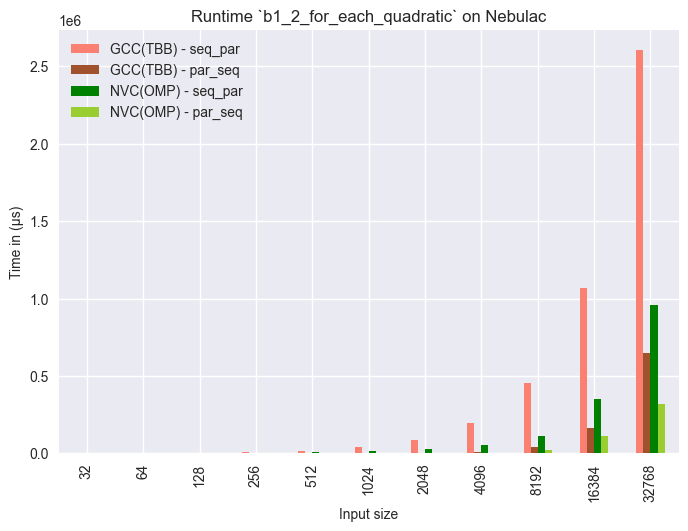

In [74]:
def get_b1_2_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## load b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par
    b1_2_for_each_quadratic_seq_par = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par__Default.csv',COMP=compiler_name)

    b1_2_for_each_quadratic_seq_par = b1_2_for_each_quadratic_seq_par.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    b1_2_for_each_quadratic_seq_par = b1_2_for_each_quadratic_seq_par.rename(columns={'real_time':f'{compiler_name} - seq_par'})

    ## load b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq
    b1_2_for_each_quadratic_par_seq = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq__Default.csv',COMP=compiler_name)

    b1_2_for_each_quadratic_par_seq = b1_2_for_each_quadratic_par_seq.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    b1_2_for_each_quadratic_par_seq = b1_2_for_each_quadratic_par_seq.rename(columns={'real_time':f'{compiler_name} - par_seq'})

    ## merge 
    return pd.merge(b1_2_for_each_quadratic_seq_par,b1_2_for_each_quadratic_par_seq, on='n')
    


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_2_data_algo(*x) for x in instances]


# merge for plotting 
b1_2_for_each_quadratic_time_merged = pd.merge(*data, on='n')

# convert time from ns to microseconds because otherwise it will look really bad
for _, compiler_name in instances:
    b1_2_for_each_quadratic_time_merged[f'{compiler_name} - par_seq'] = b1_2_for_each_quadratic_time_merged[f'{compiler_name} - par_seq'] / 1_000
    b1_2_for_each_quadratic_time_merged[f'{compiler_name} - seq_par'] = b1_2_for_each_quadratic_time_merged[f'{compiler_name} - seq_par'] / 1_000
    

# plot
ax = b1_2_for_each_quadratic_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY])
print(b1_2_for_each_quadratic_time_merged)

#plt.yscale('log', base=10)
plt.ylabel('Time in (µs)')
plt.xlabel('Input size')
plt.title('Runtime `b1_2_for_each_quadratic` on Nebulac')

plt.show()

### Strong Scaling

`S(p)= T(1) / T(p)`

As based we use once the:
* parallel algorithm (1 thread)

#### Strong Scaling - `b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par` vs `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq`

32.768 fixed input size with threads 1-64

   threads  GCC(TBB) - seq_par  GCC(TBB) - par_seq  NVC(OMP) - seq_par  \
0        1            1.000000            1.000000            1.000000   
1        2            1.979862            1.998062            1.980330   
2        4            3.750753            3.986084            3.855304   
3        8            6.238904            7.944636            7.276533   
4       16            9.478906           15.592834           11.836966   
5       32           12.198081           27.519958           16.516401   
6       64           14.887093           50.555355           15.592923   

   NVC(OMP) - par_seq  
0            1.000000  
1            2.000584  
2            3.987332  
3            7.863144  
4           15.249982  
5           25.411051  
6           32.338995  


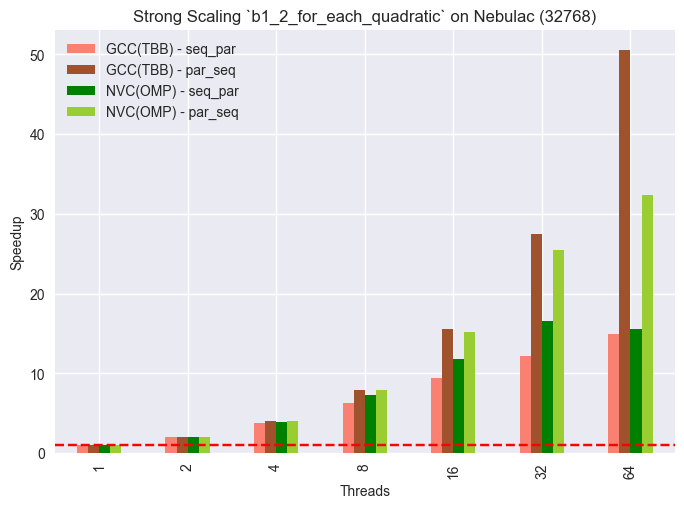

In [75]:
def get_b1_2_strong_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## Threading data
    b1_2_for_each_quadratic_seq_par_threads = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                                                                    'b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par',
                                                                                    [1,2,4,8,16,32,64],
                                                                                    COMP=compiler_name,
                                                                                    input_size=32768
                                                                                )
    

    ## calc strong scaling
    b1_2_for_each_quadratic_seq_par_strong_scaling = calc_speedup_based_par(b1_2_for_each_quadratic_seq_par_threads,
                                                                            f"{compiler_name} - seq_par",
                                                                            input_size=32768
                                                                        )


    ## load b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq
    b1_2_for_each_quadratic_par_seq_threads = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                                                                    'b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq',
                                                                                    [1,2,4,8,16,32,64],
                                                                                    COMP=compiler_name,
                                                                                    input_size=32768
                                                                                )

    ## calc strong scaling
    b1_2_for_each_quadratic_par_seq_strong_scaling = calc_speedup_based_par(b1_2_for_each_quadratic_par_seq_threads,
                                                                            f"{compiler_name} - par_seq",
                                                                            input_size=32768
                                                                        )

    ## merge
    return pd.merge(b1_2_for_each_quadratic_seq_par_strong_scaling,
                    b1_2_for_each_quadratic_par_seq_strong_scaling, 
                    on='threads'
                )


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_2_strong_scaling_algo(*x) for x in instances]

b1_2_for_each_quadratic_strong_scaling_merged = pd.merge(*data, on='threads')

print(b1_2_for_each_quadratic_strong_scaling_merged)

# plot strong scaling
ax = b1_2_for_each_quadratic_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                                                    )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_2_for_each_quadratic` on Nebulac (32768)')

plt.show()

   threads  GCC(TBB) - seq_par  GCC(TBB) - par_seq  NVC(OMP) - seq_par  \
0        1            1.000000            1.000000            1.000000   
1        2            0.989931            0.999031            0.990165   
2        4            0.937688            0.996521            0.963826   
3        8            0.779863            0.993079            0.909567   
4       16            0.592432            0.974552            0.739810   
5       32            0.381190            0.859999            0.516138   
6       64            0.232611            0.789927            0.243639   

   NVC(OMP) - par_seq  
0            1.000000  
1            1.000292  
2            0.996833  
3            0.982893  
4            0.953124  
5            0.794095  
6            0.505297  


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/3822859030.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


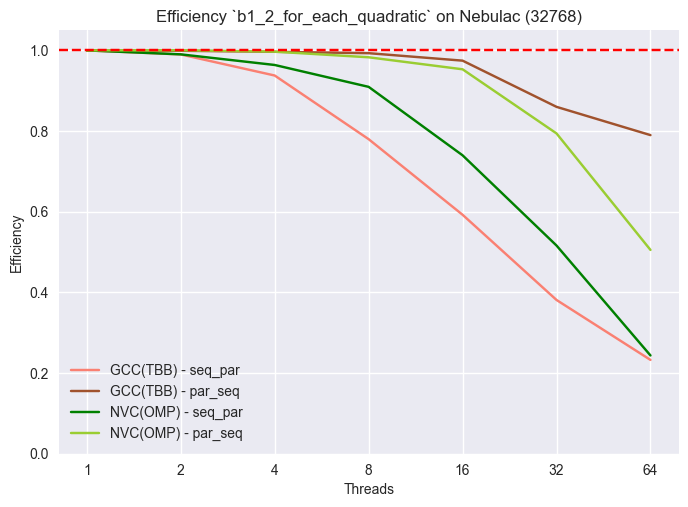

In [76]:
## efficiency graph

b1_2_for_each_quadratic_efficiency = b1_2_for_each_quadratic_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b1_2_for_each_quadratic_efficiency[f'{compiler_name} - par_seq'] = b1_2_for_each_quadratic_efficiency[f'{compiler_name} - par_seq'] / b1_2_for_each_quadratic_efficiency['threads']
    b1_2_for_each_quadratic_efficiency[f'{compiler_name} - seq_par'] = b1_2_for_each_quadratic_efficiency[f'{compiler_name} - seq_par'] / b1_2_for_each_quadratic_efficiency['threads']


print(b1_2_for_each_quadratic_efficiency)

# plot efficiency
ax = b1_2_for_each_quadratic_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                                            )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_2_for_each_quadratic` on Nebulac (32768)')

plt.show()


### Performance Portability Calculation (Inter Compiler)

Since we know that (par, seq) will be better than (seq,par) we can check the stddev of the performance improvement
from (seq, par) to (par,seq) for every compiler. For example:

```
  |          | (seq,par) | (par,seq) | faster |
  |----------|-----------|-----------|--------|
  | GCC(TBB) | 10s       | 5s        | 2x     |
  | NVC(OMP) | 12s       | 8s        | 1.5x   |
  | NVC(GPU) | 0         | 0         | 0      |
  | Intel    | 9         | 1         | 9x     |
```

stddev(2,1.5,9) = 3.4 indicating that the difference is quite significant when changing compilers.

stddev(2,1.5) = 0.25 indicating that the difference is not significant when changing compilers.

In [77]:
# calc pp_metrics

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

faster_data = []

for compiler_location, compiler_name in instances:
    print(compiler_name)

    times_faster = (b1_2_for_each_quadratic_time_merged[f'{compiler_name} - seq_par'] / b1_2_for_each_quadratic_time_merged[f'{compiler_name} - par_seq']).iloc[-1]
    faster_data.append(times_faster)

    print("\t Par_Seq faster than Seq_Par: ", times_faster)
    print()
    

print("\n")
pp_h2 = statistics.stdev(faster_data)

print("Performance Portability H2:",pp_h2)

GCC(TBB)
	 Par_Seq faster than Seq_Par:  4.000328632153124

NVC(OMP)
	 Par_Seq faster than Seq_Par:  2.9927014615871346



Performance Portability H2: 0.7125000052150252


### Findings for H2

#### `b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par` (seq_par)

The performance of seq_par exhibits significant variations when switching between compilers, particularly for larger input sizes of 8192+. The runtime differences become increasingly worse, and GCC(TBB) demonstrates poor performance in such scenarios.

As for strong scaling, seq_par's performance is rather poor. Both GCC(TBB) and NVC(OMP) experience a poor speedup after 16 threads. While GCC(TBB) exhibits minor improvements with additional threads, they are insignificant. On the other hand NVC(OMP) loses speedup once 64 threads are used. The efficiency graph shows that NVC(OMP) takes a hit at 8 threads, with both collapsing at 16 threads. Notably, NVC(OMP) starts from a higher efficiency level than GCC(TBB).

Key Observations: 
* Runtime of seq_par changes a lot from compiler to compiler
* GCC(TBB) performs really bad (runtime)
* Strong scaling of GCC(TBB) is better than NVC(OMP)
* NVC(OMP) strong scaling even worse when going 32->64 threads

#### `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq` (par_seq)

We see the same behaviour here as seen when using seq_par.  Notably, as the input sizes increase, GCC(TBB) shows a more rapid decline in performance compared to NVC(OMP). For instance, when transitioning from 16k to 32k, NVC(OMP) experiences a speedup of `2.89x`, whereas GCC(TBB) only shows a speedup of `3.98x`.

Moreover, the two backends exhibit different behavior when strong scaling. As the number of threads increases, GCC(TBB) benefits from the added resources, while NVC(OMP) takes a considerable hit and reaches peak performance at 32 threads.

Key Observations:
* Runtime difference  visible (when changing compiler)
* GCC(TBB) runtime explodes for large input size 
* NVC(OMP) runtime rises as exepcted for large input sizes
* GCC(TBB) strong scaling way better than NVC(OMP)
* NVC(OMP) strong scaling starts to slow down at 32 threads

### General

We can observe a significant difference in runtime when we switch between execution policies for inner and outer loops. This behavior is consistent across all parallel backends. In terms of runtime, GCC(TBB) shows the most substantial improvement when switching from seq_par to par_seq. However, NVC(OMP) performs better in absolute runtime numbers.

Switching from seq_par to par_seq also affects strong scaling. For smaller input sizes, the backends show similar strong scaling behavior. However, for larger thread counts (64), GCC(TBB) still shows improvements over NVC(OMP).

When switching between backends, all of them show improvement, though to varying degrees. The extent of improvement differs between the backends, as reflected in the performance portability metric calculated for this benchmark. The stddev value of 0.71 indicates that changing compilers can lead to better performance improvements.

Key Observation: 
* Changing order of execution policiy has great impact.
* Strong Scaling varies a lot by compiler 
* Absolute Runtime difference by compiler is a lot
* Improvement from seq_par to par_seq varies significantly by compiler 

#### GPU Findings

Sadly because this benchmarks use nested parallelism it wont work on the NVC(GPU).


#### Hypothesis Findings

This is hypothesis is **TRUE**! 



## H3 

> Some parallel backends exhibit better performance and scalability when handling nested parallelism for heterogeneous
> workloads

### Time

#### Time Comparison - `b1_1_for_each_linear_mandelbrot`

Check how the runtime without constraining the number of threads develops with increasing the input size

    GCC(TBB)        n  NVC(OMP)
0    25.7110       32   13.1448
1    23.8880       64   12.0237
2    26.2309      128   11.0411
3    28.5104      256   11.0437
4    32.0780      512   11.2044
5    35.4990     1024   11.4312
6    40.0559     2048   13.2587
7    44.4702     4096   14.7847
8    46.0035     8192   18.2997
9    50.1906    16384   27.9500
10   56.3977    32768   37.2332
11   65.8956    65536   61.2572
12   80.2900   131072  119.7970
13  104.1640   262144  183.0140
14  146.4930   524288  347.8630
15  223.7350  1048576  776.4000


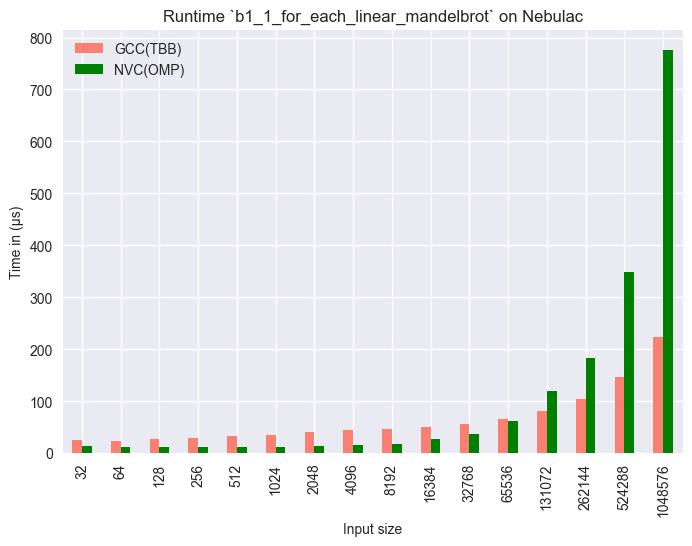

In [78]:
def get_b1_1_mandelbrot_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## load b1_1_for_each_linear_mandelbrot_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_1_for_each_linear_mandelbrot_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_1_mandelbrot_data_algo(*x) for x in instances]


# merge for plotting 
b1_1_mandelbrot_time_merged = pd.merge(*data, on='n')

# convert time from ns to microseconds because otherwise it will look really bad
for _, compiler_name in instances:
    b1_1_mandelbrot_time_merged[f'{compiler_name}'] = b1_1_mandelbrot_time_merged[f'{compiler_name}'] / 1_000


# plot
ax = b1_1_mandelbrot_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])
print(b1_1_mandelbrot_time_merged)

#plt.yscale('log', base=2)
plt.ylabel('Time in (µs)')
plt.xlabel('Input size')
plt.title('Runtime `b1_1_for_each_linear_mandelbrot` on Nebulac')

plt.show()

#### Time Comparison - `b1_2_for_each_quadratic_mandelbrot`

Check how the runtime without constraining the number of threads develops with increasing the input size

       GCC(TBB)      n    NVC(OMP)
0       52.6922     32     14.3070
1       66.4682     64     12.9766
2      102.1700    128     17.3404
3      208.8140    256     25.2010
4      495.2330    512     42.5719
5     1210.1300   1024     82.0095
6     3186.5900   2048    174.3940
7     9017.7100   4096    621.8690
8    19850.9000   8192   2358.0000
9    45629.3000  16384   9165.8000
10  111974.0000  32768  39351.2000


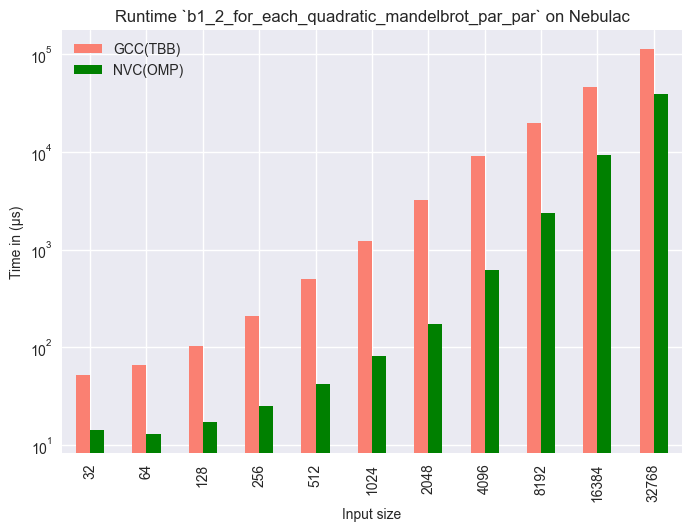

In [79]:
def get_b1_2_mandelbrot_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## load b1_2_for_each_quadratic_mandelbrot_par_par
    df_par_par = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_mandelbrot_outer_std::execution::parallel_policy_par__Default.csv',COMP=compiler_name)

    df_par_par = df_par_par.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df_par_par = df_par_par.rename(columns={'real_time':f'{compiler_name}'})

    ## load b1_2_for_each_quadratic_mandelbrot_par_seq
    """df_par_seq = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_mandelbrot_outer_std::execution::parallel_policy_seq__Default.csv',COMP=compiler_name)

    df_par_seq = df_par_seq.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df_par_seq = df_par_seq.rename(columns={'real_time':f'{compiler_name} - par_seq'})"""


    return df_par_par


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_2_mandelbrot_data_algo(*x) for x in instances]

# merge for plotting 
b1_2_mandelbrot_time_merged = pd.merge(*data, on='n')

# convert time from ns to microseconds because otherwise it will look really bad
for _, compiler_name in instances:
    b1_2_mandelbrot_time_merged[f'{compiler_name}'] = b1_2_mandelbrot_time_merged[f'{compiler_name}'] / 1_000
    #b1_2_mandelbrot_time_merged[f'{compiler_name} - par_seq'] = b1_2_mandelbrot_time_merged[f'{compiler_name} - par_seq'] / 1_000


# plot
ax = b1_2_mandelbrot_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])
print(b1_2_mandelbrot_time_merged)

plt.yscale('log', base=10)
plt.ylabel('Time in (µs)')
plt.xlabel('Input size')
plt.title('Runtime `b1_2_for_each_quadratic_mandelbrot_par_par` on Nebulac')

plt.show()

### Strong Scaling

`S(p)= T(1) / T(p)`

As based we use: parallel algorithm (1 thread)

#### Strong scaling - `b1_1_for_each_linear_mandelbrot`

1M fixed input size with threads 1-64

   threads   GCC(TBB)  NVC(OMP)
0        1   1.000000  1.000000
1        2   1.996081  1.451250
2        4   3.926398  1.795026
3        8   7.410093  3.234524
4       16  13.015673  4.066618
5       32  21.870544  6.280458
6       64  30.747455  8.625019


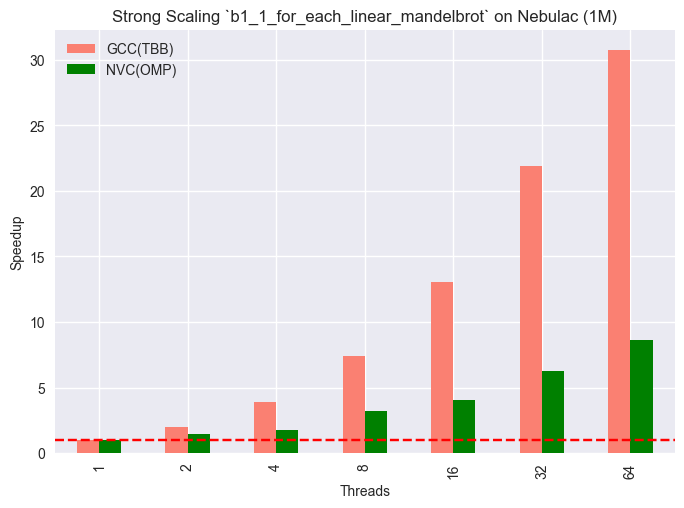

In [80]:
def get_b1_1_mandelbrot_strong_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## b1_1_for_each_linear_mandelbrot_threaded
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b1_1_for_each_linear_mandelbrot_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_par(df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_1_mandelbrot_strong_scaling_algo(*x) for x in instances]

b1_1_for_each_linear_mandelbrot_strong_scaling_merged = pd.merge(*data, on='threads')

print(b1_1_for_each_linear_mandelbrot_strong_scaling_merged)

# plot strong scaling
ax = b1_1_for_each_linear_mandelbrot_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR]
                                                    )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_1_for_each_linear_mandelbrot` on Nebulac (1M)')
plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  1.000000  1.000000
1        2  0.998040  0.725625
2        4  0.981600  0.448757
3        8  0.926262  0.404316
4       16  0.813480  0.254164
5       32  0.683455  0.196264
6       64  0.480429  0.134766


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/1548625966.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


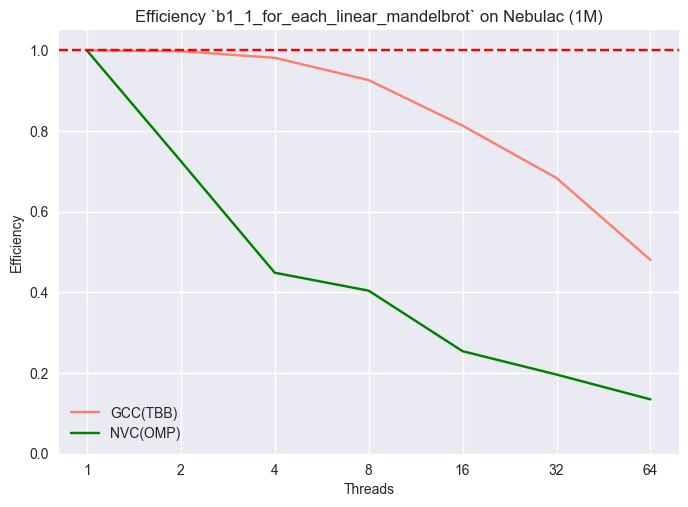

In [81]:
# efficiency graph

b1_1_for_each_linear_mandelbrot_efficiency = b1_1_for_each_linear_mandelbrot_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b1_1_for_each_linear_mandelbrot_efficiency[f'{compiler_name}'] = b1_1_for_each_linear_mandelbrot_efficiency[f'{compiler_name}'] / b1_1_for_each_linear_mandelbrot_efficiency['threads']
    


print(b1_1_for_each_linear_mandelbrot_efficiency)

# plot efficiency
ax = b1_1_for_each_linear_mandelbrot_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR]
                                            )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_1_for_each_linear_mandelbrot` on Nebulac (1M)')

plt.show()

#### Strong scaling - `b1_2_for_each_quadratic_mandelbrot`

32768 fixed input size with threads 1-64

   threads   GCC(TBB)   NVC(OMP)
0        1   1.000000   1.000000
1        2   2.049499   1.971748
2        4   4.059636   3.828575
3        8   8.035183   7.838173
4       16  16.078846  13.673510
5       32  29.304273  25.362917
6       64  53.257833  52.008864


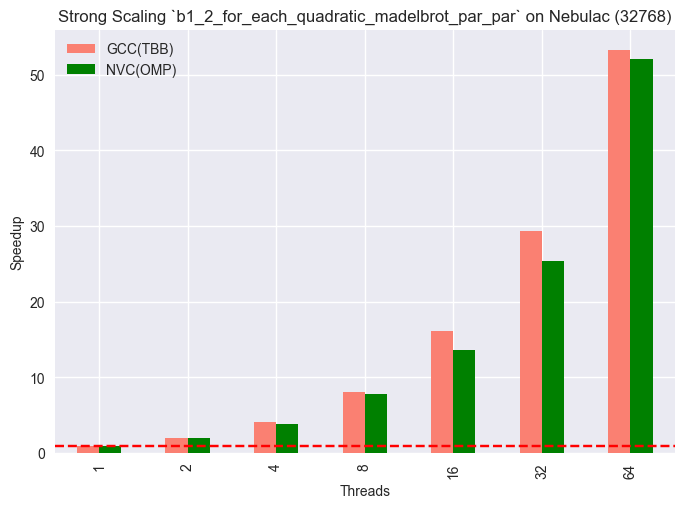

In [82]:
def get_b1_2_mandelbrot_strong_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## Threading data par_par
    par_par_threads = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                                                                    'b1_2_for_each_quadratic_mandelbrot_outer_std::execution::parallel_policy_par',
                                                                                    [1,2,4,8,16,32,64],
                                                                                    COMP=compiler_name,
                                                                                    input_size=32768
                                                                                )
    

    ## calc strong scaling
    return calc_speedup_based_par(par_par_threads,
                                                    f"{compiler_name}", 
                                                    input_size=32768
                                                )


# load b1_2_for_each_quadratic_mandelbrot_threaded 

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_2_mandelbrot_strong_scaling_algo(*x) for x in instances]

b1_2_for_each_quadratic_mandelbrot_strong_scaling_merged = pd.merge(*data, on='threads')


print(b1_2_for_each_quadratic_mandelbrot_strong_scaling_merged)

# plot strong scaling
ax = b1_2_for_each_quadratic_mandelbrot_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR]
                                                    )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_2_for_each_quadratic_madelbrot_par_par` on Nebulac (32768)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  1.000000  1.000000
1        2  1.024749  0.985874
2        4  1.014909  0.957144
3        8  1.004398  0.979772
4       16  1.004928  0.854594
5       32  0.915759  0.792591
6       64  0.832154  0.812639


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14303/425741610.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


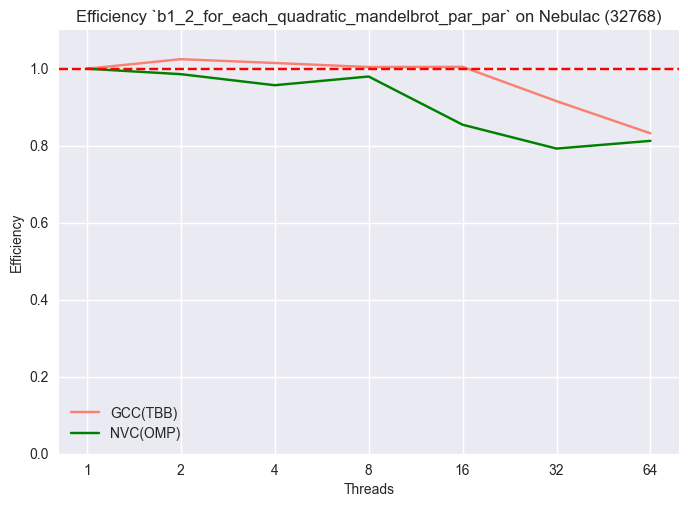

In [83]:
# efficiency graph


b1_2_for_each_quadratic_mandelbrot_efficiency = b1_2_for_each_quadratic_mandelbrot_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b1_2_for_each_quadratic_mandelbrot_efficiency[f'{compiler_name}'] = b1_2_for_each_quadratic_mandelbrot_efficiency[f'{compiler_name}'] / b1_1_for_each_linear_mandelbrot_efficiency['threads']
    


print(b1_2_for_each_quadratic_mandelbrot_efficiency)

# plot efficiency
ax = b1_2_for_each_quadratic_mandelbrot_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR]
                                            )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0,1.10)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_2_for_each_quadratic_mandelbrot_par_par` on Nebulac (32768)')

plt.show()

### Instructions per second (Ips)

//TODO

In [84]:
#TODO: do this!!!

### Performance Portability Calculation (Inter Compiler)

NONE

### Findings for H3


#### Findings `b1_1_for_each_linear_mandelbrot`

From our runtime analysis we can see that GCC(TBB) has significant better performance than NVC(OMP). For small input sizes up to 2^16 the performance is about the same for both backends. For larger heterogenous workloads the performance of NVC(OMP) collapses and GCC(TBB) shines with its rather fast runtime. I cannot confirm this because I have not read through the code but I can remember to have read that GCC(TBB) does work stealing. This would explain why GCC(TBB) performs so good in comparison.

This poor performance of NVC(OMP) continues when looking at its strong scaling behavior. Already for small number of threads (4) the speedup is really poorly leading to efficiency of 40% and less. Compared to NVC(OMP), GCC(TBB) has fairly good strong scaling. Although for higher number of threads it seems to slowly top off. Moving from 32 to 64 threads does not bring a huge improvement.

//TODO: IPS

Key Observations:
* GCC(TBB) works really well with heterogenous workloads.
* NVC(OMP) struggles a lot with large input sizes 
* NVC(OMP) has really bad strong scaling 
* GCC(TBB) great scaling but slows down at 32->64 threads

#### Findings `b1_2_for_each_quadratic_mandelbrot`

The runtime analysis shows that GCC(TBB) has quite bad runtime compared to NVC(OMP). The runtime of NVC(OMP) especially on smaller input sizes is by a magnitude faster. For larger input sizes NVC(OMP) slowly gets worse but still way better than GCC(TBB). 

Strong Scaling is quite interesting for GCC(TBB). For up to 16 threads we have perfect speedup, for 32 and 64 threads we have around 80-90% efficiency. NVC(OMP) nearly follows this trend, since perfect speedup stops at 8 threads and even before we seem to be around 99% all the time. From 16 till 64 threads the speedup seems to be stable not with an efficiency of about 80%.

//TODO: IPS

Key Observations:
* GCC(TBB) runtime is quite bad comparing to NVC(OMP)
* NVC(OMP) has great runtime for small input sizes but for larger input sizes it collapses.
* Strong Scaling of GCC(TBB) is quite strange. Perfect speedup until 16 threads. Then slowly degrades
* NVC(OMP) Strong scaling nearly perfect speedup until 8 Threads. Then collapses really fast.


#### GPU Findings

Although it is possible to rewrite the code of b1_1_linear_mandelbrot to run on gpus nebula does not support GPUS.


### Hypothesis Findings

This hypothesis is **true**!
